# Model Training For Germany Renewable Energy Production Forecasting

### Pre-Training

Let's start by importing the required libraries:
- Numpy & Pandas : For dataset and matrix operations,
- Matplotlib & Seaborn : For data visualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Then import the data and fill in the NaN data looking backwards and forwards in time:

In [2]:
dataset = pd.read_csv("time_series_60min_singleindex.csv")
DE_Solar_Gen_Act = dataset.loc[:, ['DE_solar_generation_actual']]

DE_Solar_Gen_Act = DE_Solar_Gen_Act.interpolate(method='linear', axis=0, limit_direction='both')
DE_Solar_Gen_Act = DE_Solar_Gen_Act.values

print('DE_Solar_Gen_Act shape :', np.shape(DE_Solar_Gen_Act))

DE_Solar_Gen_Act shape : (34165, 1)


Let's visualize our data for a quick review and comparison with the future state:

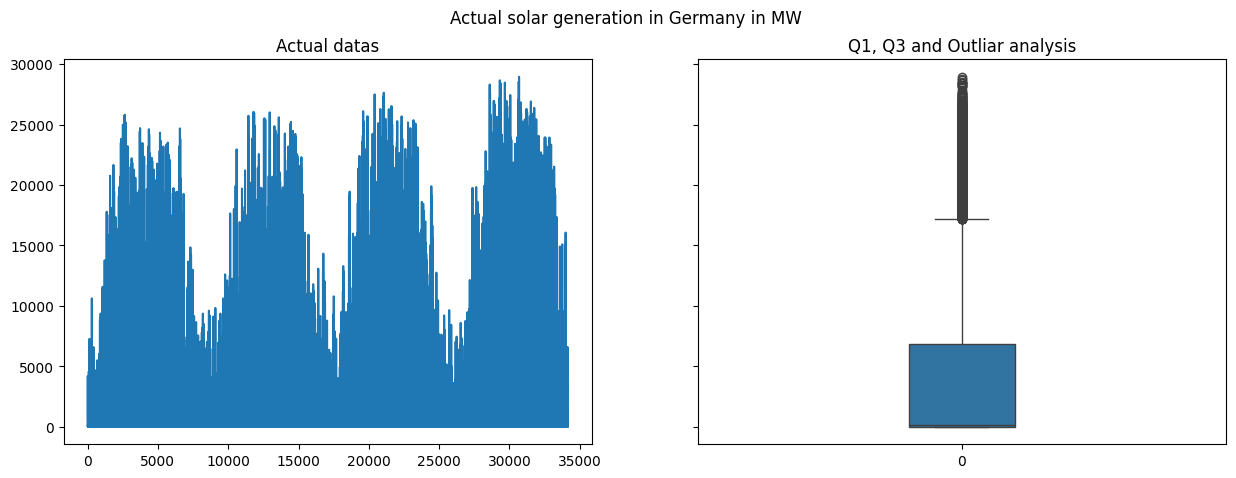

In [3]:
figure, axis = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
figure.suptitle('Actual solar generation in Germany in MW')

axis[0].plot(DE_Solar_Gen_Act)
axis[0].set_title("Actual datas")

sns.boxplot(ax=axis[1], data=DE_Solar_Gen_Act, width = 0.2)
axis[1].set_title("Q1, Q3 and Outliar analysis")

plt.show()

Then let's scale the data (LSTM generally works better with data normalized between 0-1):

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(DE_Solar_Gen_Act)

scaled_data

array([[0.00245208],
       [0.00245208],
       [0.00245208],
       ...,
       [0.07825937],
       [0.10910033],
       [0.11973752]])

Then split the data into training and test sets:

In [5]:
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

print("Train size: {}, Test size: {} ".format(len(train_data), len(test_data)))

Train size: 23915, Test size: 10250 


Let's visualize our min-max scaled and train-test split data once again:

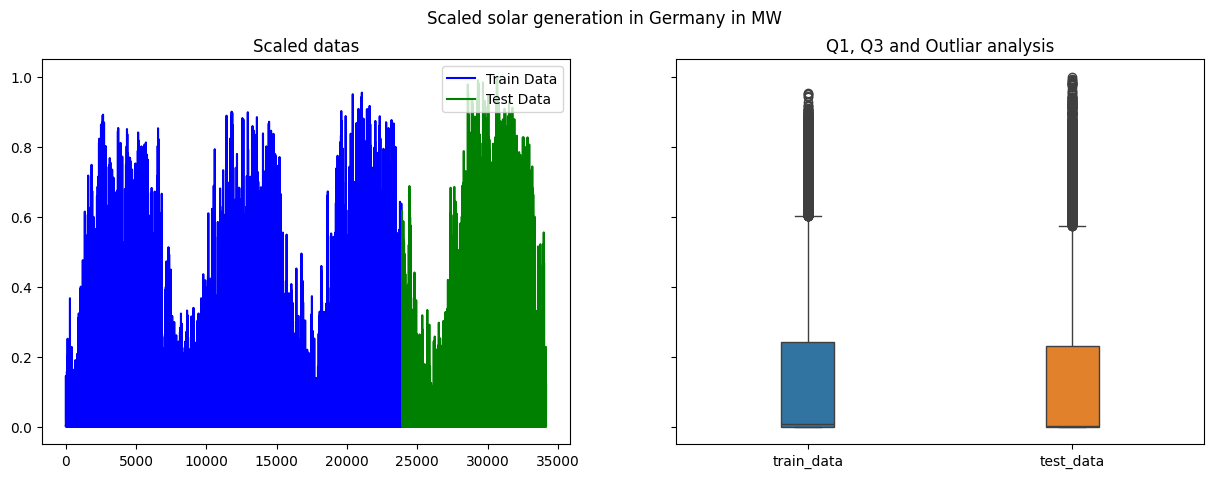

In [6]:
figure, axis = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
figure.suptitle('Scaled solar generation in Germany in MW')

axis[0].plot(range(len(train_data)), train_data, label="Train Data", color="blue")

axis[0].plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label="Test Data", color="green")
axis[0].legend(loc='upper right')
axis[0].set_title("Scaled datas")

compare_df = pd.Series(train_data[:,0], name="train_data").to_frame().join(pd.Series(test_data[:,0], name="test_data").to_frame())
sns.boxplot(ax=axis[1], data=compare_df, width = 0.2)
axis[1].set_title("Q1, Q3 and Outliar analysis")

plt.show()

After that, we need to complete an important step to train the time series with the LSTM algorithm. According to the “timestemp” we have determined, we need to prepare our dataset for the training phase of the model we have created with LSTM neurons by windowing it. We can think of this as a sequence of length “timestemp” [60 (hours | 2.5 days) in our example] traveling through the data:

In [7]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("Train size: {}, Test size: {} ".format(X_train.shape, X_test.shape))

Train size: (23854, 60), Test size: (10189, 60) 


Since the LSTM objects in the tensorflow library require 3 dimentional input (tensor), let's transform our data into a tensor:

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Create and Train The Model

In order for our AI model to predict the future, we first need to create a model and train it with the data we have. For this, let's first import the necessary classes:
- Sequential : For adding the values given with the ".add" method side by side (hidden layers),
- Dense : For LSTM outputs to be collected and produce results,
- LSTM : For analyse data,
- EarlyStopping : For avoid everfitting.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

Then, let's create the “early stopping” object to prevent our model from memorizing the data we have and producing wrong results:

In [10]:
callback = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    patience=10,
    verbose=0,
    min_delta=1e-5
)

Then we can prepare the template for our model and compaile it! The accuracy rates of our model will change according to the hyperparameter values we enter:

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(60, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Now, it is time to train (fit) our model:

In [12]:
model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.0239
Epoch 2/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.0018
Epoch 3/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 9.7616e-04
Epoch 4/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 6.5573e-04
Epoch 5/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 4.5864e-04
Epoch 6/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 3.2635e-04
Epoch 7/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 2.7126e-04
Epoch 8/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 2.2227e-04
Epoch 9/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 2.1102e-04
Epoch 10/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 1.7062e-04
Epoch 11/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 2.1337e-04
Epoch 12/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 1.5576e-04
Epoch 13/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 1.6018e-04
Epoch 14/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step 

### Test the Model

After training our model, let's predict the future on the time series x_train and x_test data:

In [13]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

print(f"Train predictions: {train_predict[:5]}")
print(f"Test predictions: {test_predict[:5]}")

746/746 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Train predictions: [[1818.1346  ]
 [1211.4187  ]
 [ 550.71454 ]
 [ 136.1345  ]
 [  24.963795]]
Test predictions: [[15.981218]
 [21.436638]
 [27.079218]
 [29.614807]
 [28.357456]]


And check our accuracy:

Train Score: 7489.58 RMSE
Test Score: 8008.36 RMSE


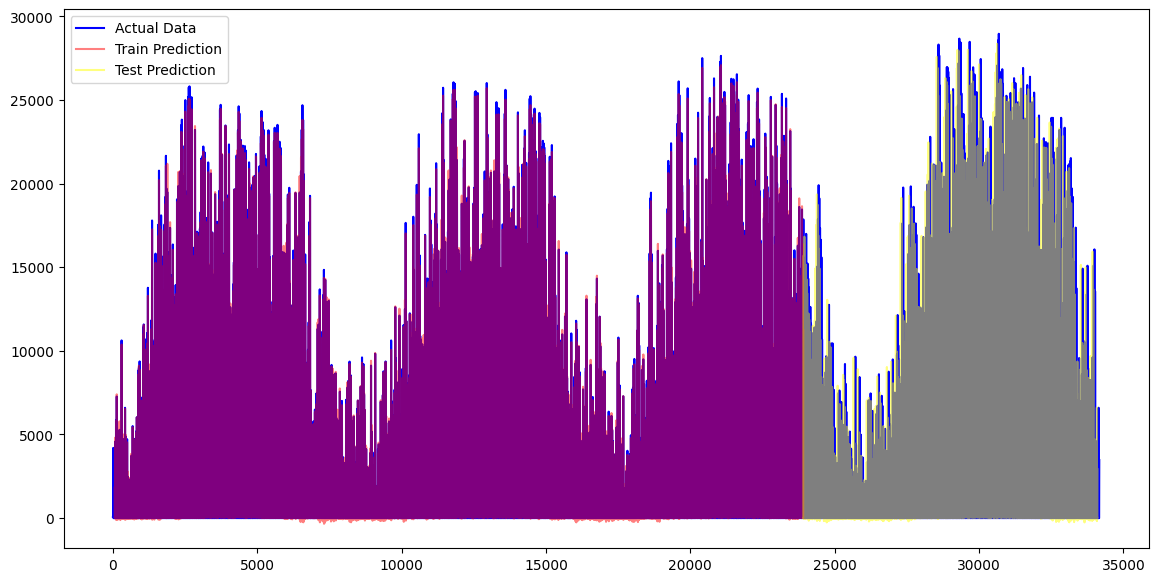

In [15]:
from sklearn.metrics import mean_squared_error

trainScore = (mean_squared_error(y_train, train_predict[:,0])) ** 0.5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = (mean_squared_error(y_test, test_predict[:,0])) ** 0.5
print('Test Score: %.2f RMSE' % (testScore))


train_len = len(train_predict) + time_step
test_len = len(test_predict)

plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_data), label="Actual Data", color="blue")
plt.plot(np.arange(time_step, train_len), train_predict, label="Train Prediction",alpha=0.5, color= "red")
plt.plot(np.arange(train_len, train_len + test_len), test_predict, label="Test Prediction", alpha=0.5, color= "yellow")
plt.legend()
plt.show()

So we built an artificial intelligence model and trained it.